### Transformer Encoder model
> KU-HAR dataset | __action without high dynamic actions [jump, stair-down, run]__

In [23]:
import logging

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("Loading packages ...")

import os
import sys
import time
import pickle
import json
from argparse import Namespace

# 3rd party packages
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Project modules
from src.options import Options
from src.running import setup, pipeline_factory, validate, check_progress, NEG_METRICS
from src.utils import utils
from src.datasets.data import data_factory, Normalizer
from src.datasets.datasplit import split_dataset
from src.models.ts_transformer import model_factory
from src.models.loss import get_loss_module
from src.optimizers import get_optimizer

import neptune.new as neptune

2022-09-24 09:28:40,079 | INFO : Loading packages ...


In [24]:
run = neptune.init(
    project="FYP-Group22/Transformer-SSC",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

https://app.neptune.ai/FYP-Group22/Transformer-SSC/e/TRAN-35
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [25]:
config = {}
config["output_dir"] = './tmp'
config["seed"] = 123
config["gpu"] = "0" # activate gpu > o, on cpu > -1
config["n_proc"] = 1

# loading pre-trained model
config["load_model"] = None
config["test_only"] = None
config["config_filepath"] = None

# experiment config
config["task"] = "classification"
config["experiment_name"] = "first_test"
config["no_timestamp"] = True

# dataset settings
config["limit_size"] = 300 
config["data_class"] = 'kuhar'
config["data_dir"] = '../../Data/KU-HAR_time_domain_subsamples_20750x300.csv'
config["val_ratio"] = 0.1 
config["test_ratio"] = 0.1 
config["norm_from"] = False 
config["normalization"] = None #'standardization'
config["record_file"] = "./tmp/Imputation_records.xls"
config["records_file"] = "./tmp/records.xls"
config["num_workers"] = 0
config["console"] = True
config["save_all"] = False
config["comment"] = "mvts_transformer (AvgPool+Dense) | KU-HAR dataset Low-Versitaile Actions | nipdep 1DConv processing layer | first test"

# test, val from seperate files 
config["test_pattern"] = False 
config["val_pattern"] = False 
config["test_from"] = False

# freeze model weight for fine-tunning
config["freeze"] = False

# if task is a imputation 
config["masking_ratio"] = 0.15
config["mean_mask_length"] = 5
config["mask_mode"] = "seperate"
config["mask_distribution"] = "geometric"
config["exclude_feats"] = None 
config["mask_feats"] = '0, 1'
config["start_hint"] = 0.0
config["end_hint"] = 0.0 
config["harden"] = True

# model parameters
config['model'] = 'transformer'
config["pos_encoding"] = "learnable"
config["d_model"] = 128 
config["dim_feedforward"] = 256
config["num_heads"] = 8
config["num_layers"] = 3
config["dropout"] = 0.1
config["activation"] = 'relu'
config["normalization_layer"] = "BatchNorm"
config["data_window_len"] = None 
config["max_seq_len"] = 300

# model training parameters
config["epochs"] = 10
config["lr"] = 0.0005
config["val_interval"] = 1
config["lr_step"] = '1000'
config["lr_factor"] = '0.1'
config["l2_reg"] = 0
config["global_reg"] = True
config["key_metric"] = "loss"
config["optimizer"] = "Adam"
config["batch_size"] = 32
config["print_interval"] = 1

setup(config)

2022-09-24 09:28:42,136 | INFO : Stored configuration file in './tmp\first_test'


{'output_dir': './tmp\\first_test',
 'seed': 123,
 'gpu': '0',
 'n_proc': 1,
 'load_model': None,
 'test_only': None,
 'config_filepath': None,
 'task': 'classification',
 'experiment_name': 'first_test',
 'no_timestamp': True,
 'limit_size': 300,
 'data_class': 'kuhar',
 'data_dir': '../../Data/KU-HAR_time_domain_subsamples_20750x300.csv',
 'val_ratio': 0.1,
 'test_ratio': 0.1,
 'norm_from': False,
 'normalization': None,
 'record_file': './tmp/Imputation_records.xls',
 'records_file': './tmp/records.xls',
 'num_workers': 0,
 'console': True,
 'save_all': False,
 'comment': 'mvts_transformer (AvgPool+Dense) | KU-HAR dataset Low-Versitaile Actions | nipdep 1DConv processing layer | first test',
 'test_pattern': False,
 'val_pattern': False,
 'test_from': False,
 'freeze': False,
 'masking_ratio': 0.15,
 'mean_mask_length': 5,
 'mask_mode': 'seperate',
 'mask_distribution': 'geometric',
 'exclude_feats': None,
 'mask_feats': '0, 1',
 'start_hint': 0.0,
 'end_hint': 0.0,
 'harden': True,

In [26]:
run["parameters"] = config
# config['class_names'] = ['Talk-sit', 'Talk-stand', 'Stand-sit', 'Lay-stand', 'Pick', 'Jump', 'Push-up', 'Sit-up', 'Walk', 'Walk-backward', 'Walk-circle', 'Run', 'Stair-up', 'Stair-down', 'Table-tennis']
config['class_names'] = ['Stand', 'Sit', 'Talk-sit', 'Talk-stand', 'Stand-sit', 'Lay', 'Lay-stand', 'Pick', 'Jump', 'Push-up', 'Sit-up', 'Walk', 'Walk-backward', 'Walk-circle', 'Run', 'Stair-up', 'Stair-down', 'Table-tennis']

In [27]:
total_epoch_time = 0
total_eval_time = 0

total_start_time = time.time()

# Add file logging besides stdout
file_handler = logging.FileHandler(os.path.join(config['output_dir'], 'output.log'))
logger.addHandler(file_handler)

logger.info('Running:\n{}\n'.format(' '.join(sys.argv)))  # command used to run

if config['seed'] is not None:
    torch.manual_seed(config['seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info("Using device: {}".format(device))
if device == 'cuda':
    logger.info("Device index: {}".format(torch.cuda.current_device()))

2022-09-24 09:28:42,521 | INFO : Running:
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9019 --control=9017 --hb=9016 --Session.signature_scheme="hmac-sha256" --Session.key=b"a31ff839-9edb-4f26-bae5-1439010d12d7" --shell=9018 --transport="tcp" --iopub=9020 --f=c:\Users\deela\AppData\Roaming\jupyter\runtime\kernel-v2-18796zMrggYj1ZjCV.json

2022-09-24 09:28:42,524 | INFO : Using device: cuda


In [28]:
# Build data
logger.info("Loading and preprocessing data ...")
data_class = data_factory[config['data_class']]
my_data = data_class(config['data_dir'], n_proc=config['n_proc'], limit_size=config['limit_size'], config=config, filter_classes=[8, 14, 16])
feat_dim = my_data.feature_df.shape[1]  # dimensionality of data features
if config['task'] == 'classification':
    validation_method = 'StratifiedShuffleSplit'
    labels = my_data.labels_df.label.values
    print(labels)
else:
    validation_method = 'ShuffleSplit'
    labels = None

2022-09-24 09:28:42,800 | INFO : Loading and preprocessing data ...


[0 0 0 ... 8 8 8]


In [29]:
# Split dataset
test_data = my_data
test_indices = None  # will be converted to empty list in `split_dataset`, if also test_set_ratio == 0
val_data = my_data
val_indices = []
if config['test_pattern']:  # used if test data come from different files / file patterns
    test_data = data_class(config['data_dir'], n_proc=-1, config=config)
    test_indices = test_data.all_IDs
if config['test_from']:  # load test IDs directly from file, if available, otherwise use `test_set_ratio`. Can work together with `test_pattern`
    test_indices = list(set([line.rstrip() for line in open(config['test_from']).readlines()]))
    try:
        test_indices = [int(ind) for ind in test_indices]  # integer indices
    except ValueError:
        pass  # in case indices are non-integers
    logger.info("Loaded {} test IDs from file: '{}'".format(len(test_indices), config['test_from']))
if config['val_pattern']:  # used if val data come from different files / file patterns
    val_data = data_class(config['data_dir'], n_proc=-1, config=config)
    val_indices = val_data.all_IDs

# Note: currently a validation set must exist, either with `val_pattern` or `val_ratio`
# Using a `val_pattern` means that `val_ratio` == 0 and `test_ratio` == 0
if config['val_ratio'] > 0:
    train_indices, val_indices, test_indices = split_dataset(data_indices=my_data.all_IDs,
                                                                validation_method=validation_method,
                                                                n_splits=1,
                                                                validation_ratio=config['val_ratio'],
                                                                test_set_ratio=config['test_ratio'],  # used only if test_indices not explicitly specified
                                                                test_indices=test_indices,
                                                                random_seed=1337,
                                                                labels=labels)
    train_indices = train_indices[0]  # `split_dataset` returns a list of indices *per fold/split*
    val_indices = val_indices[0]  # `split_dataset` returns a list of indices *per fold/split*
else:
    train_indices = my_data.all_IDs
    if test_indices is None:
        test_indices = []

logger.info("{} samples may be used for training".format(len(train_indices)))
logger.info("{} samples will be used for validation".format(len(val_indices)))
logger.info("{} samples will be used for testing".format(len(test_indices)))

with open(os.path.join(config['output_dir'], 'data_indices.json'), 'w') as f:
    try:
        json.dump({'train_indices': list(map(int, train_indices)),
                    'val_indices': list(map(int, val_indices)),
                    'test_indices': list(map(int, test_indices))}, f, indent=4)
    except ValueError:  # in case indices are non-integers
        json.dump({'train_indices': list(train_indices),
                    'val_indices': list(val_indices),
                    'test_indices': list(test_indices)}, f, indent=4)

2022-09-24 09:30:13,403 | INFO : 15152 samples may be used for training
2022-09-24 09:30:13,404 | INFO : 1684 samples will be used for validation
2022-09-24 09:30:13,405 | INFO : 1871 samples will be used for testing


In [30]:
# Pre-process features
normalizer = None
if config['norm_from']:
    with open(config['norm_from'], 'rb') as f:
        norm_dict = pickle.load(f)
    normalizer = Normalizer(**norm_dict)
elif config['normalization'] is not None:
    normalizer = Normalizer(config['normalization'])
    my_data.feature_df.loc[train_indices] = normalizer.normalize(my_data.feature_df.loc[train_indices])
    if not config['normalization'].startswith('per_sample'):
        # get normalizing values from training set and store for future use
        norm_dict = normalizer.__dict__
        with open(os.path.join(config['output_dir'], 'normalization.pickle'), 'wb') as f:
            pickle.dump(norm_dict, f, pickle.HIGHEST_PROTOCOL)
if normalizer is not None:
    if len(val_indices):
        print("Validation dataset normalization")
        val_data.feature_df.loc[val_indices] = normalizer.normalize(val_data.feature_df.loc[val_indices])
    if len(test_indices):
        print("Test dataset normalization")
        test_data.feature_df.loc[test_indices] = normalizer.normalize(test_data.feature_df.loc[test_indices])

In [31]:
# Create model
logger.info("Creating model ...")
model = model_factory(config, my_data)

if config['freeze']:
    for name, param in model.named_parameters():
        if name.startswith('output_layer'):
            param.requires_grad = True
        else:
            param.requires_grad = False

logger.info("Model:\n{}".format(model))
logger.info("Total number of parameters: {}".format(utils.count_parameters(model)))
logger.info("Trainable parameters: {}".format(utils.count_parameters(model, trainable=True)))


2022-09-24 09:30:13,518 | INFO : Creating model ...
2022-09-24 09:30:13,530 | INFO : Model:
TSTransformerEncoderClassiregressor(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.1, inplace=False)
      

In [32]:
# Initialize optimizer

if config['global_reg']:
    weight_decay = config['l2_reg']
    output_reg = None
else:
    weight_decay = 0
    output_reg = config['l2_reg']

optim_class = get_optimizer(config['optimizer'])
optimizer = optim_class(model.parameters(), lr=config['lr'], weight_decay=weight_decay)

start_epoch = 0
lr_step = 0  # current step index of `lr_step`
lr = config['lr']  # current learning step
# Load model and optimizer state
if config["load_model"]:
    model, optimizer, start_epoch = utils.load_model(model, config['load_model'], optimizer, config['resume'],
                                                        config['change_output'],
                                                        config['lr'],
                                                        config['lr_step'],
                                                        config['lr_factor'])
model.to(device)

loss_module = get_loss_module(config)

if config['test_only'] == 'testset':  # Only evaluate and skip training
    dataset_class, collate_fn, runner_class = pipeline_factory(config)
    test_dataset = dataset_class(test_data, test_indices)

    test_loader = DataLoader(dataset=test_dataset,
                                batch_size=config['batch_size'],
                                shuffle=False,
                                num_workers=config['num_workers'],
                                pin_memory=True,
                                collate_fn=lambda x: collate_fn(x, max_len=model.max_len))
    test_evaluator = runner_class(model, test_loader, device, loss_module,
                                        print_interval=config['print_interval'], console=config['console'])
    aggr_metrics_test, per_batch_test = test_evaluator.evaluate(keep_all=True)
    print_str = 'Test Summary: '
    for k, v in aggr_metrics_test.items():
        print_str += '{}: {:8f} | '.format(k, v)
    logger.info(print_str)
    # return

In [33]:
# Initialize data generators
dataset_class, collate_fn, runner_class = pipeline_factory(config)
val_dataset = dataset_class(val_data, val_indices)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config['batch_size'],
                        shuffle=False,
                        num_workers=config['num_workers'],
                        pin_memory=True,
                        collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

train_dataset = dataset_class(my_data, train_indices)

train_loader = DataLoader(dataset=train_dataset,
                            batch_size=config['batch_size'],
                            shuffle=True,
                            num_workers=config['num_workers'],
                            pin_memory=True,
                            collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

trainer = runner_class(model, train_loader, device, loss_module, optimizer, l2_reg=output_reg,
                                print_interval=config['print_interval'], console=config['console'])
val_evaluator = runner_class(model, val_loader, device, loss_module,
                                    print_interval=config['print_interval'], console=config['console'])

tensorboard_writer = SummaryWriter(config['tensorboard_dir'])

best_value = 1e16 if config['key_metric'] in NEG_METRICS else -1e16  # initialize with +inf or -inf depending on key metric
metrics = []  # (for validation) list of lists: for each epoch, stores metrics like loss, ...
best_metrics = {}

In [34]:
# for i in train_loader:
#     print(i)
#     break

2022-09-24 09:30:21,354 | INFO : Evaluating on validation set ...


Evaluating Epoch 0  98.1% | batch:        52 of        53	|	loss: 2.70487

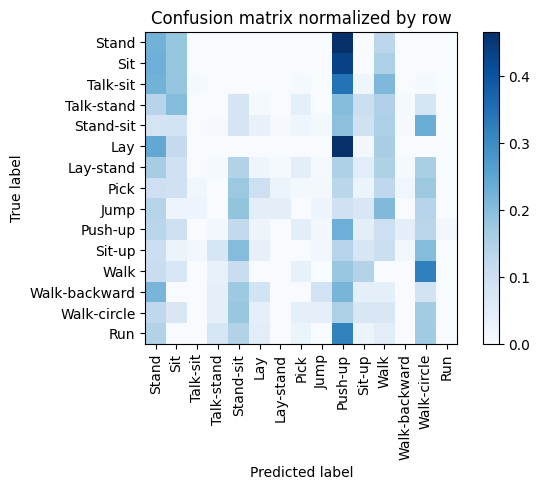

Overall accuracy: 0.075

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.113      0.077      0.091      0.116        196|	 Walk-circle: 0.235,	Push-up: 0.194,	Walk: 0.153,	
        Stand       0.136      0.224      0.169      0.101        170|	 Push-up: 0.465,	Sit: 0.182,	
          Sit       0.150      0.183      0.165      0.100        169|	 Push-up: 0.432,	Stand: 0.231,	
   Talk-stand       0.000      0.000      0.000      0.100        168|	 Push-up: 0.202,	Sit: 0.202,	Walk: 0.149,	
          Lay       0.000      0.000      0.000      0.097        163|	 Push-up: 0.466,	Stand: 0.245,	Walk: 0.160,	
     Talk-sit       0.200      0.006      0.012      0.096        162|	 Push-up: 0.346,	Stand: 0.222,	Walk: 0.210,	
    Lay-stand       0.143      0.006      0.012      0.094        159|	 Stand: 0.164,	Walk-circle: 0.157,	Walk: 0.151,	
         Pick       0.034      0.008      0.013      0.071        120|	 Walk-circle: 0.175,	St

2022-09-24 09:30:27,342 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.987046480178833 seconds

2022-09-24 09:30:27,342 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.951556503772736 seconds
2022-09-24 09:30:27,343 | INFO : Avg batch val. time: 0.1311614434674101 seconds
2022-09-24 09:30:27,344 | INFO : Avg sample val. time: 0.004128002674449368 seconds
2022-09-24 09:30:27,346 | INFO : Epoch 0 Validation Summary: epoch: 0.000000 | loss: 0.085864 | accuracy: 0.075416 | precision: 0.088425 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
2022-09-24 09:30:27,374 | INFO : Starting training...





Distribution of classes with respect to PRECISION: 
[0.0, 0.2): 14
[0.2, 0.4): 1
[0.4, 0.6): 0
[0.6, 0.7): 0
[0.7, 0.8): 0
[0.8, 0.9): 0
[0.9, 1.0): 0
[1.0, 1.1): 0


Distribution of classes with respect to RECALL: 
[0.0, 0.2): 13
[0.2, 0.4): 2
[0.4, 0.6): 0
[0.6, 0.7): 0
[0.7, 0.8): 0
[0.8, 0.9): 0
[0.9, 1.0): 0
[1.0, 1.1): 0



Training Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 1  99.8% | batch:       473 of       474	|	loss: 0.731278

2022-09-24 09:33:28,001 | INFO : Epoch 1 Training Summary: epoch: 1.000000 | loss: 0.030898 | 
2022-09-24 09:33:28,001 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 0.6234235763549805 seconds

2022-09-24 09:33:28,002 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 0.6234235763549805 seconds
2022-09-24 09:33:28,003 | INFO : Avg batch train. time: 0.38106207505560125 seconds
2022-09-24 09:33:28,004 | INFO : Avg sample train. time: 0.011920764491575699 seconds
2022-09-24 09:33:28,005 | INFO : Evaluating on validation set ...


Evaluating Epoch 1  98.1% | batch:        52 of        53	|	loss: 0.658013

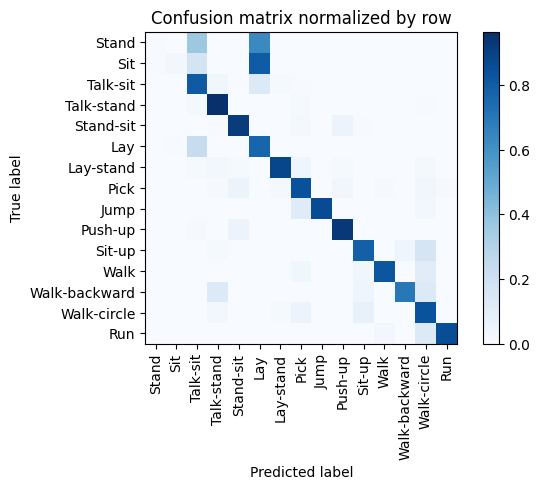

2022-09-24 09:33:33,910 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.903504848480225 seconds

2022-09-24 09:33:33,910 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.870937145673311 seconds
2022-09-24 09:33:33,911 | INFO : Avg batch val. time: 0.12964032350327 seconds
2022-09-24 09:33:33,912 | INFO : Avg sample val. time: 0.004080128946361824 seconds
2022-09-24 09:33:33,913 | INFO : Epoch 1 Validation Summary: epoch: 1.000000 | loss: 0.023811 | accuracy: 0.690024 | precision: 0.747121 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  10%|█         | 1/10 [03:06<27:58, 186.55s/it]

Overall accuracy: 0.690

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.928      0.918      0.923      0.116        196|	 Push-up: 0.056,	Pick: 0.015,	
        Stand       0.500      0.006      0.012      0.101        170|	 Lay: 0.629,	Talk-sit: 0.365,	
          Sit       0.800      0.024      0.046      0.100        169|	 Lay: 0.799,	Talk-sit: 0.172,	
   Talk-stand       0.900      0.964      0.931      0.100        168|	 Talk-sit: 0.018,	Pick: 0.012,	
          Lay       0.322      0.767      0.454      0.097        163|	 Talk-sit: 0.227,	Sit: 0.006,	
     Talk-sit       0.494      0.809      0.614      0.096        162|	 Lay: 0.130,	Talk-stand: 0.037,	
    Lay-stand       0.966      0.881      0.921      0.094        159|	 Pick: 0.038,	Talk-stand: 0.025,	
         Pick       0.821      0.842      0.831      0.071        120|	 Stand-sit: 0.050,	Walk-circle: 0.033,	
      Push-up       0.833      0.934      0.881      0.

2022-09-24 09:36:36,595 | INFO : Epoch 2 Training Summary: epoch: 2.000000 | loss: 0.021013 | 
2022-09-24 09:36:36,596 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 2.661121368408203 seconds

2022-09-24 09:36:36,596 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 1.6422724723815918 seconds
2022-09-24 09:36:36,598 | INFO : Avg batch train. time: 0.3832115453003831 seconds
2022-09-24 09:36:36,598 | INFO : Avg sample train. time: 0.011988006366973442 seconds
2022-09-24 09:36:36,599 | INFO : Evaluating on validation set ...


Evaluating Epoch 2  98.1% | batch:        52 of        53	|	loss: 0.476933

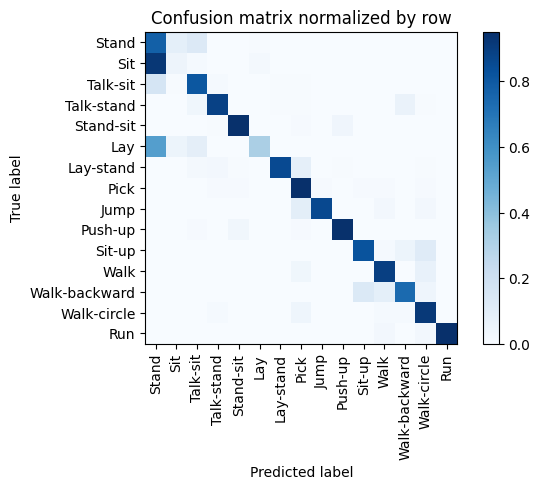

2022-09-24 09:36:42,544 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.94303297996521 seconds

2022-09-24 09:36:42,545 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.804658276694162 seconds
2022-09-24 09:36:42,545 | INFO : Avg batch val. time: 0.12838977880555022 seconds
2022-09-24 09:36:42,546 | INFO : Avg sample val. time: 0.004040770948155678 seconds
2022-09-24 09:36:42,548 | INFO : Epoch 2 Validation Summary: epoch: 2.000000 | loss: 0.019254 | accuracy: 0.737530 | precision: 0.773174 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  20%|██        | 2/10 [06:15<25:02, 187.78s/it]

Overall accuracy: 0.738

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.974      0.944      0.959      0.116        196|	 Push-up: 0.041,	Pick: 0.010,	
        Stand       0.328      0.776      0.462      0.101        170|	 Talk-sit: 0.129,	Sit: 0.088,	
          Sit       0.250      0.047      0.080      0.100        169|	 Stand: 0.923,	Lay: 0.018,	
   Talk-stand       0.943      0.887      0.914      0.100        168|	 Walk-backward: 0.060,	Talk-sit: 0.036,	
          Lay       0.929      0.319      0.475      0.097        163|	 Stand: 0.540,	Talk-sit: 0.092,	
     Talk-sit       0.728      0.809      0.766      0.096        162|	 Stand: 0.160,	Talk-stand: 0.012,	
    Lay-stand       0.986      0.855      0.916      0.094        159|	 Pick: 0.082,	Talk-stand: 0.025,	
         Pick       0.814      0.950      0.877      0.071        120|	 Walk-circle: 0.008,	Walk: 0.008,	
      Push-up       0.905      0.945      0.925   

2022-09-24 09:40:19,716 | INFO : Epoch 3 Training Summary: epoch: 3.000000 | loss: 0.018329 | 
2022-09-24 09:40:19,717 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 37.148961544036865 seconds

2022-09-24 09:40:19,718 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 13.477835496266692 seconds
2022-09-24 09:40:19,719 | INFO : Avg batch train. time: 0.4081810875448664 seconds
2022-09-24 09:40:19,720 | INFO : Avg sample train. time: 0.012769128530640621 seconds
2022-09-24 09:40:19,722 | INFO : Evaluating on validation set ...


Evaluating Epoch 3  98.1% | batch:        52 of        53	|	loss: 0.400194

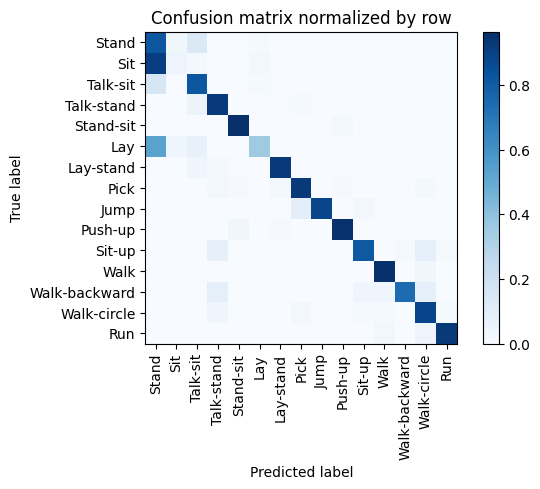

2022-09-24 09:40:25,943 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 6.220995187759399 seconds

2022-09-24 09:40:25,943 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.76574740409851 seconds
2022-09-24 09:40:25,944 | INFO : Avg batch val. time: 0.1276556113980851 seconds
2022-09-24 09:40:25,945 | INFO : Avg sample val. time: 0.00401766472927465 seconds
2022-09-24 09:40:25,946 | INFO : Epoch 3 Validation Summary: epoch: 3.000000 | loss: 0.018605 | accuracy: 0.757720 | precision: 0.791141 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  30%|███       | 3/10 [09:58<23:48, 204.04s/it]

Overall accuracy: 0.758

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.974      0.964      0.969      0.116        196|	 Push-up: 0.020,	Lay-stand: 0.005,	
        Stand       0.344      0.818      0.484      0.101        170|	 Talk-sit: 0.135,	Sit: 0.035,	
          Sit       0.364      0.047      0.084      0.100        169|	 Stand: 0.911,	Lay: 0.024,	
   Talk-stand       0.897      0.929      0.912      0.100        168|	 Talk-sit: 0.054,	Pick: 0.012,	
          Lay       0.879      0.356      0.507      0.097        163|	 Stand: 0.528,	Talk-sit: 0.074,	
     Talk-sit       0.711      0.821      0.762      0.096        162|	 Stand: 0.154,	Lay: 0.012,	
    Lay-stand       0.961      0.925      0.942      0.094        159|	 Talk-sit: 0.038,	Talk-stand: 0.019,	
         Pick       0.925      0.925      0.925      0.071        120|	 Talk-stand: 0.025,	Walk-circle: 0.017,	
      Push-up       0.935      0.956      0.946    

2022-09-24 09:43:53,941 | INFO : Epoch 4 Training Summary: epoch: 4.000000 | loss: 0.017348 | 
2022-09-24 09:43:53,942 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 27.975095987319946 seconds

2022-09-24 09:43:53,944 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 17.10215061903 seconds
2022-09-24 09:43:53,947 | INFO : Avg batch train. time: 0.41582732198107597 seconds
2022-09-24 09:43:53,949 | INFO : Avg sample train. time: 0.013008325674434398 seconds
2022-09-24 09:43:53,951 | INFO : Evaluating on validation set ...


Evaluating Epoch 4  98.1% | batch:        52 of        53	|	loss: 0.491809

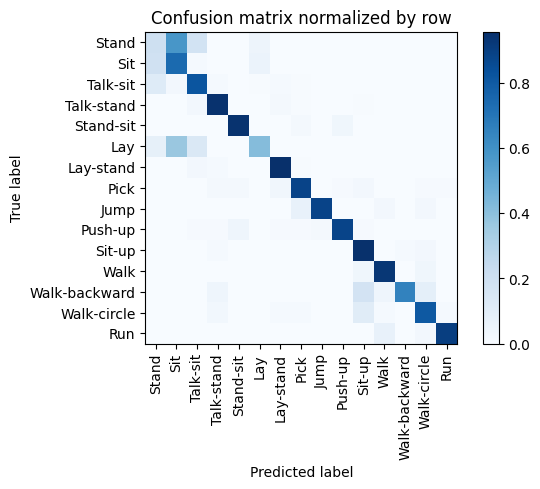

2022-09-24 09:44:00,881 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 6.928030014038086 seconds

2022-09-24 09:44:00,882 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.775890067219734 seconds
2022-09-24 09:44:00,883 | INFO : Avg batch val. time: 0.12784698240037234 seconds
2022-09-24 09:44:00,883 | INFO : Avg sample val. time: 0.004023687688372764 seconds
2022-09-24 09:44:00,885 | INFO : Epoch 4 Validation Summary: epoch: 4.000000 | loss: 0.018488 | accuracy: 0.766627 | precision: 0.775965 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  40%|████      | 4/10 [13:33<20:50, 208.35s/it]

Overall accuracy: 0.767

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.969      0.944      0.956      0.116        196|	 Push-up: 0.036,	Pick: 0.020,	
        Stand       0.347      0.200      0.254      0.101        170|	 Sit: 0.576,	Talk-sit: 0.176,	
          Sit       0.436      0.740      0.548      0.100        169|	 Stand: 0.189,	Lay: 0.059,	
   Talk-stand       0.935      0.946      0.941      0.100        168|	 Talk-sit: 0.024,	Lay-stand: 0.018,	
          Lay       0.782      0.417      0.544      0.097        163|	 Sit: 0.368,	Talk-sit: 0.135,	
     Talk-sit       0.679      0.821      0.743      0.096        162|	 Stand: 0.117,	Sit: 0.025,	
    Lay-stand       0.933      0.956      0.944      0.094        159|	 Talk-sit: 0.025,	Talk-stand: 0.013,	
         Pick       0.898      0.883      0.891      0.071        120|	 Lay-stand: 0.033,	Sit-up: 0.025,	
      Push-up       0.909      0.879      0.894      0.054 

2022-09-24 09:47:21,880 | INFO : Epoch 5 Training Summary: epoch: 5.000000 | loss: 0.016581 | 
2022-09-24 09:47:21,881 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 20.960004329681396 seconds

2022-09-24 09:47:21,883 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 17.87372136116028 seconds
2022-09-24 09:47:21,886 | INFO : Avg batch train. time: 0.4174551083568782 seconds
2022-09-24 09:47:21,888 | INFO : Avg sample train. time: 0.013059247713909733 seconds
2022-09-24 09:47:21,889 | INFO : Evaluating on validation set ...


Evaluating Epoch 5  98.1% | batch:        52 of        53	|	loss: 0.497766

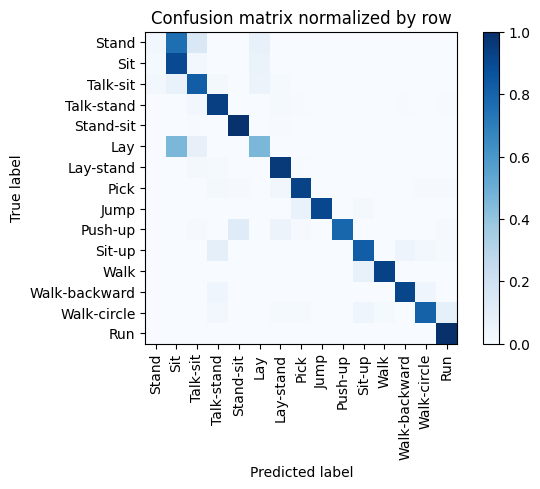

2022-09-24 09:47:28,357 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 6.4670250415802 seconds

2022-09-24 09:47:28,358 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.757721536299762 seconds
2022-09-24 09:47:28,359 | INFO : Avg batch val. time: 0.1275041799301842 seconds
2022-09-24 09:47:28,360 | INFO : Avg sample val. time: 0.004012898774524799 seconds
2022-09-24 09:47:28,361 | INFO : Epoch 5 Validation Summary: epoch: 5.000000 | loss: 0.017454 | accuracy: 0.773753 | precision: 0.786665 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  50%|█████     | 5/10 [17:01<17:20, 208.03s/it]

Overall accuracy: 0.774

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.942      0.990      0.965      0.116        196|	 Lay-stand: 0.005,	Talk-sit: 0.005,	
        Stand       0.455      0.029      0.055      0.101        170|	 Sit: 0.759,	Talk-sit: 0.141,	Lay: 0.071,	
          Sit       0.414      0.899      0.567      0.100        169|	 Lay: 0.065,	Talk-sit: 0.024,	
   Talk-stand       0.903      0.940      0.921      0.100        168|	 Talk-sit: 0.030,	Lay-stand: 0.012,	
          Lay       0.701      0.460      0.556      0.097        163|	 Sit: 0.460,	Talk-sit: 0.080,	
     Talk-sit       0.723      0.821      0.769      0.096        162|	 Sit: 0.068,	Lay: 0.056,	
    Lay-stand       0.911      0.962      0.936      0.094        159|	 Talk-sit: 0.019,	Talk-stand: 0.013,	
         Pick       0.941      0.925      0.933      0.071        120|	 Lay-stand: 0.033,	Talk-stand: 0.017,	
      Push-up       1.000      0.791

2022-09-24 09:50:39,259 | INFO : Epoch 6 Training Summary: epoch: 6.000000 | loss: 0.015622 | 
2022-09-24 09:50:39,260 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 10.876745700836182 seconds

2022-09-24 09:50:39,261 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 16.707558751106262 seconds
2022-09-24 09:50:39,262 | INFO : Avg batch train. time: 0.4149948496858782 seconds
2022-09-24 09:50:39,263 | INFO : Avg sample train. time: 0.01298228344450279 seconds
2022-09-24 09:50:39,264 | INFO : Evaluating on validation set ...


Evaluating Epoch 6  98.1% | batch:        52 of        53	|	loss: 0.460273

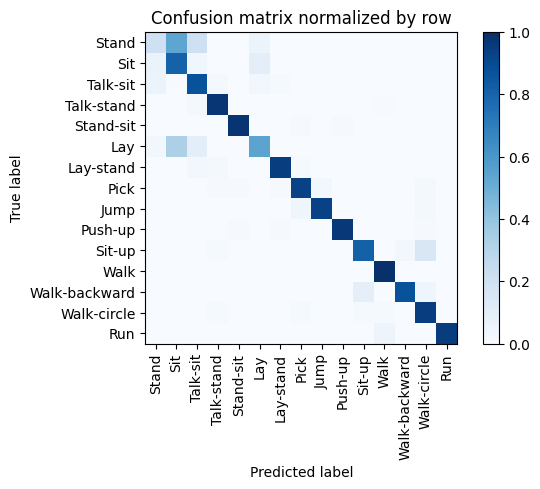

2022-09-24 09:50:45,460 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 6.194999694824219 seconds

2022-09-24 09:50:45,462 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.726459211773342 seconds
2022-09-24 09:50:45,465 | INFO : Avg batch val. time: 0.12691432475044043 seconds
2022-09-24 09:50:45,467 | INFO : Avg sample val. time: 0.003994334448796521 seconds
2022-09-24 09:50:45,473 | INFO : Epoch 6 Validation Summary: epoch: 6.000000 | loss: 0.014816 | accuracy: 0.811164 | precision: 0.820764 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  60%|██████    | 6/10 [20:18<13:37, 204.32s/it]

Overall accuracy: 0.811

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.990      0.980      0.985      0.116        196|	 Push-up: 0.010,	Pick: 0.010,	
        Stand       0.574      0.206      0.303      0.101        170|	 Sit: 0.535,	Talk-sit: 0.206,	
          Sit       0.484      0.805      0.604      0.100        169|	 Lay: 0.095,	Stand: 0.065,	
   Talk-stand       0.948      0.976      0.962      0.100        168|	 Talk-sit: 0.018,	Walk: 0.006,	
          Lay       0.748      0.546      0.631      0.097        163|	 Sit: 0.325,	Talk-sit: 0.098,	
     Talk-sit       0.688      0.870      0.768      0.096        162|	 Stand: 0.062,	Lay: 0.031,	
    Lay-stand       0.974      0.943      0.958      0.094        159|	 Talk-sit: 0.025,	Talk-stand: 0.019,	
         Pick       0.941      0.933      0.937      0.071        120|	 Jump: 0.025,	Walk-circle: 0.017,	
      Push-up       0.978      0.967      0.972      0.054      

2022-09-24 09:53:54,781 | INFO : Epoch 7 Training Summary: epoch: 7.000000 | loss: 0.015128 | 
2022-09-24 09:53:54,782 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 9.271331787109375 seconds

2022-09-24 09:53:54,782 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 15.645240613392417 seconds
2022-09-24 09:53:54,783 | INFO : Avg batch train. time: 0.4127536721801528 seconds
2022-09-24 09:53:54,784 | INFO : Avg sample train. time: 0.012912172690957789 seconds
2022-09-24 09:53:54,785 | INFO : Evaluating on validation set ...


Evaluating Epoch 7  98.1% | batch:        52 of        53	|	loss: 0.498682

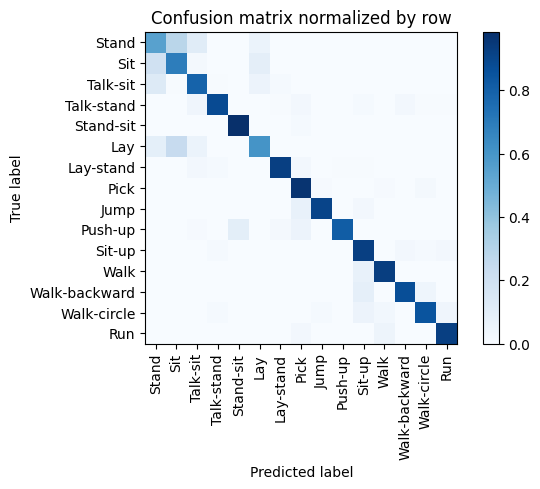

2022-09-24 09:54:00,731 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.945804119110107 seconds

2022-09-24 09:54:00,731 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.685372101633172 seconds
2022-09-24 09:54:00,732 | INFO : Avg batch val. time: 0.12613909625722966 seconds
2022-09-24 09:54:00,735 | INFO : Avg sample val. time: 0.003969935927335613 seconds
2022-09-24 09:54:00,738 | INFO : Epoch 7 Validation Summary: epoch: 7.000000 | loss: 0.015919 | accuracy: 0.814727 | precision: 0.821019 | 
Training Epoch:  70%|███████   | 7/10 [23:33<10:04, 201.35s/it]

Overall accuracy: 0.815

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.955      0.985      0.970      0.116        196|	 Pick: 0.015,	Run: 0.000,	
        Stand       0.574      0.547      0.560      0.101        170|	 Sit: 0.282,	Talk-sit: 0.112,	
          Sit       0.571      0.692      0.626      0.100        169|	 Stand: 0.195,	Lay: 0.095,	
   Talk-stand       0.967      0.881      0.922      0.100        168|	 Talk-sit: 0.042,	Walk-backward: 0.024,	
          Lay       0.739      0.607      0.667      0.097        163|	 Sit: 0.239,	Stand: 0.092,	
     Talk-sit       0.744      0.790      0.766      0.096        162|	 Stand: 0.130,	Lay: 0.056,	
    Lay-stand       0.967      0.925      0.945      0.094        159|	 Pick: 0.025,	Talk-sit: 0.025,	
         Pick       0.853      0.967      0.906      0.071        120|	 Walk-circle: 0.017,	Walk: 0.008,	
      Push-up       0.987      0.813      0.892      0.054         9

2022-09-24 09:57:10,125 | INFO : Epoch 8 Training Summary: epoch: 8.000000 | loss: 0.014390 | 
2022-09-24 09:57:10,126 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 9.381836891174316 seconds

2022-09-24 09:57:10,127 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 14.862315148115158 seconds
2022-09-24 09:57:10,129 | INFO : Avg batch train. time: 0.41110193069222606 seconds
2022-09-24 09:57:10,131 | INFO : Avg sample train. time: 0.01286050126373516 seconds
2022-09-24 09:57:10,132 | INFO : Evaluating on validation set ...


Evaluating Epoch 8  98.1% | batch:        52 of        53	|	loss: 0.500587

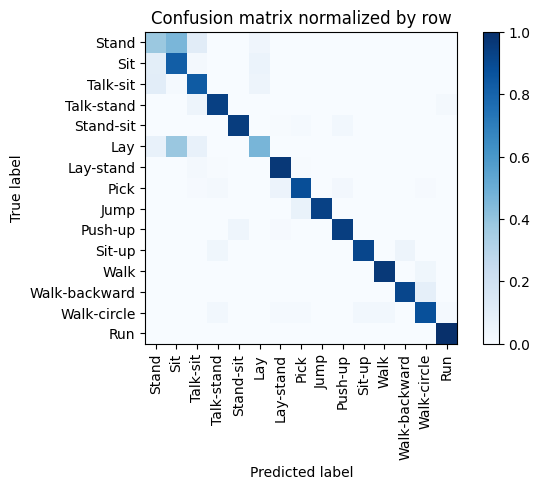

2022-09-24 09:57:16,347 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 6.21402907371521 seconds

2022-09-24 09:57:16,347 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.661804950237274 seconds
2022-09-24 09:57:16,348 | INFO : Avg batch val. time: 0.1256944330233448 seconds
2022-09-24 09:57:16,349 | INFO : Avg sample val. time: 0.0039559411818511124 seconds
2022-09-24 09:57:16,350 | INFO : Epoch 8 Validation Summary: epoch: 8.000000 | loss: 0.014834 | accuracy: 0.812352 | precision: 0.826212 | 
Training Epoch:  80%|████████  | 8/10 [26:48<06:39, 199.52s/it]

Overall accuracy: 0.812

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.979      0.949      0.964      0.116        196|	 Push-up: 0.031,	Pick: 0.015,	
        Stand       0.586      0.382      0.463      0.101        170|	 Sit: 0.465,	Talk-sit: 0.112,	
          Sit       0.491      0.822      0.615      0.100        169|	 Stand: 0.101,	Lay: 0.059,	
   Talk-stand       0.952      0.935      0.943      0.100        168|	 Talk-sit: 0.048,	Run: 0.018,	
          Lay       0.752      0.466      0.576      0.097        163|	 Sit: 0.387,	Talk-sit: 0.074,	
     Talk-sit       0.746      0.833      0.787      0.096        162|	 Stand: 0.105,	Lay: 0.049,	
    Lay-stand       0.939      0.969      0.954      0.094        159|	 Talk-sit: 0.019,	Pick: 0.006,	
         Pick       0.930      0.883      0.906      0.071        120|	 Lay-stand: 0.058,	Push-up: 0.025,	
      Push-up       0.905      0.945      0.925      0.054         91|

2022-09-24 10:00:27,769 | INFO : Epoch 9 Training Summary: epoch: 9.000000 | loss: 0.014204 | 
2022-09-24 10:00:27,770 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 11.416363716125488 seconds

2022-09-24 10:00:27,771 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 14.479431655671874 seconds
2022-09-24 10:00:27,771 | INFO : Avg batch train. time: 0.4102941596111221 seconds
2022-09-24 10:00:27,772 | INFO : Avg sample train. time: 0.012835231761857965 seconds
2022-09-24 10:00:27,774 | INFO : Evaluating on validation set ...


Evaluating Epoch 9  98.1% | batch:        52 of        53	|	loss: 0.517989

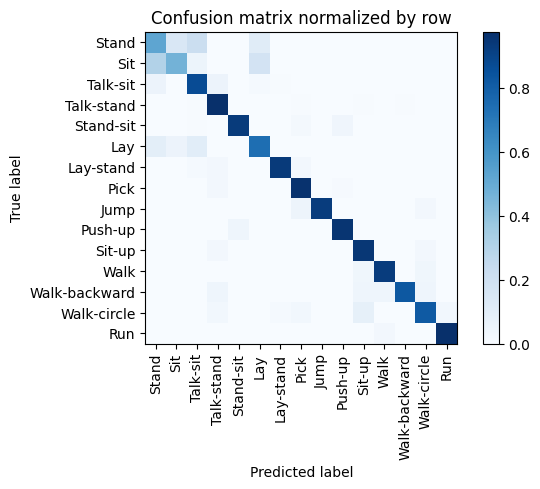

2022-09-24 10:00:33,882 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 6.107995510101318 seconds

2022-09-24 10:00:33,883 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.635433072135562 seconds
2022-09-24 10:00:33,883 | INFO : Avg batch val. time: 0.1251968504176521 seconds
2022-09-24 10:00:33,885 | INFO : Avg sample val. time: 0.003940280921695702 seconds
2022-09-24 10:00:33,888 | INFO : Epoch 9 Validation Summary: epoch: 9.000000 | loss: 0.015000 | accuracy: 0.824228 | precision: 0.824910 | 
Training Epoch:  90%|█████████ | 9/10 [30:06<03:18, 198.90s/it]

Overall accuracy: 0.824

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.979      0.934      0.956      0.116        196|	 Push-up: 0.041,	Pick: 0.020,	
        Stand       0.539      0.524      0.531      0.101        170|	 Talk-sit: 0.218,	Sit: 0.147,	
          Sit       0.699      0.467      0.560      0.100        169|	 Stand: 0.302,	Lay: 0.178,	
   Talk-stand       0.886      0.976      0.929      0.100        168|	 Walk-backward: 0.006,	Sit-up: 0.006,	
          Lay       0.703      0.742      0.722      0.097        163|	 Talk-sit: 0.104,	Stand: 0.098,	
     Talk-sit       0.678      0.870      0.762      0.096        162|	 Talk-stand: 0.056,	Stand: 0.056,	
    Lay-stand       0.987      0.937      0.961      0.094        159|	 Pick: 0.025,	Talk-stand: 0.025,	
         Pick       0.899      0.967      0.932      0.071        120|	 Talk-stand: 0.025,	Push-up: 0.008,	
      Push-up       0.906      0.956      0.930   

2022-09-24 10:03:43,837 | INFO : Epoch 10 Training Summary: epoch: 10.000000 | loss: 0.013565 | 
2022-09-24 10:03:43,837 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 9.944644927978516 seconds

2022-09-24 10:03:43,838 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 14.025952982902538 seconds
2022-09-24 10:03:43,840 | INFO : Avg batch train. time: 0.4093374535504273 seconds
2022-09-24 10:03:43,841 | INFO : Avg sample train. time: 0.012805303127171498 seconds
2022-09-24 10:03:43,842 | INFO : Evaluating on validation set ...


Evaluating Epoch 10  98.1% | batch:        52 of        53	|	loss: 0.445302

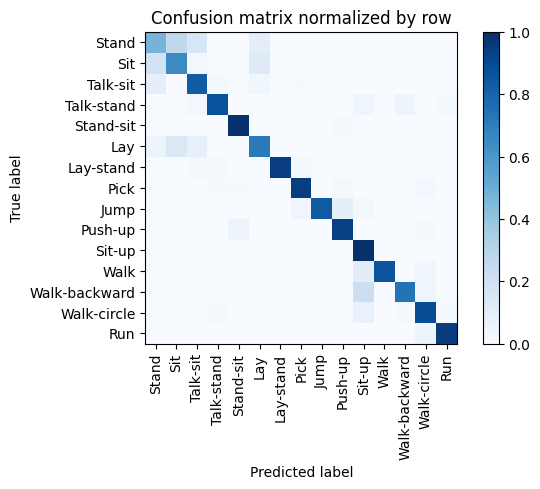

2022-09-24 10:03:49,810 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.967031955718994 seconds

2022-09-24 10:03:49,811 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.605051203207537 seconds
2022-09-24 10:03:49,811 | INFO : Avg batch val. time: 0.12462360760768937 seconds
2022-09-24 10:03:49,812 | INFO : Avg sample val. time: 0.003922239431833454 seconds
2022-09-24 10:03:49,813 | INFO : Epoch 10 Validation Summary: epoch: 10.000000 | loss: 0.015075 | accuracy: 0.824228 | precision: 0.825488 | 
2022-09-24 10:03:49,819 | INFO : Best loss was 0.014815812669428963. Other metrics: OrderedDict([('epoch', 6), ('loss', 0.014815812669428963), ('accuracy', 0.8111638954869359), ('precision', 0.8207641863579015)])
2022-09-24 10:03:49,820 | INFO : All Done!
2022-09-24 10:03:49,821 | INFO : Total runtime: 0.0 hours, 35.0 minutes, 7.303123712539673 seconds



Overall accuracy: 0.824

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.965      0.990      0.977      0.116        196|	 Push-up: 0.010,	Run: 0.000,	
        Stand       0.583      0.476      0.524      0.101        170|	 Sit: 0.271,	Talk-sit: 0.159,	
          Sit       0.611      0.651      0.630      0.100        169|	 Stand: 0.195,	Lay: 0.124,	
   Talk-stand       0.948      0.869      0.907      0.100        168|	 Walk-backward: 0.048,	Sit-up: 0.042,	
          Lay       0.730      0.712      0.720      0.097        163|	 Sit: 0.147,	Talk-sit: 0.080,	
     Talk-sit       0.720      0.827      0.770      0.096        162|	 Stand: 0.093,	Lay: 0.037,	
    Lay-stand       0.993      0.943      0.968      0.094        159|	 Pick: 0.019,	Talk-stand: 0.019,	
         Pick       0.934      0.942      0.938      0.071        120|	 Walk-circle: 0.025,	Push-up: 0.017,	
      Push-up       0.914      0.934      0.924      0.054 

In [35]:
# Evaluate on validation before training
aggr_metrics_val, best_metrics, best_value = validate(val_evaluator, tensorboard_writer, config, best_metrics,
                                                        best_value, epoch=0, class_names=config['class_names'])
metrics_names, metrics_values = zip(*aggr_metrics_val.items())
metrics.append(list(metrics_values))

logger.info('Starting training...')
for epoch in tqdm(range(start_epoch + 1, config["epochs"] + 1), desc='Training Epoch', leave=False):
    mark = epoch if config['save_all'] else 'last'
    epoch_start_time = time.time()
    aggr_metrics_train = trainer.train_epoch(epoch)  # dictionary of aggregate epoch metrics
    # print(f"train metrics >> {aggr_metrics_train}")
    run['train/loss'].log(aggr_metrics_train['loss'])
    epoch_runtime = time.time() - epoch_start_time
    print_str = 'Epoch {} Training Summary: '.format(epoch)
    for k, v in aggr_metrics_train.items():
        tensorboard_writer.add_scalar('{}/train'.format(k), v, epoch)
        print_str += '{}: {:8f} | '.format(k, v)
    logger.info(print_str)
    logger.info("Epoch runtime: {} hours, {} minutes, {} seconds\n".format(*utils.readable_time(epoch_runtime)))
    total_epoch_time += epoch_runtime
    avg_epoch_time = total_epoch_time / (epoch - start_epoch)
    avg_batch_time = avg_epoch_time / len(train_loader)
    avg_sample_time = avg_epoch_time / len(train_dataset)
    logger.info("Avg epoch train. time: {} hours, {} minutes, {} seconds".format(*utils.readable_time(avg_epoch_time)))
    logger.info("Avg batch train. time: {} seconds".format(avg_batch_time))
    logger.info("Avg sample train. time: {} seconds".format(avg_sample_time))

    # evaluate if first or last epoch or at specified interval
    if (epoch == config["epochs"]) or (epoch == start_epoch + 1) or (epoch % config['val_interval'] == 0):
        aggr_metrics_val, best_metrics, best_value = validate(val_evaluator, tensorboard_writer, config,
                                                                best_metrics, best_value, epoch, config['class_names'])
        # print(f"eval metrics >> {aggr_metrics_val}")
        run['eval/loss'].log(aggr_metrics_val['loss'])
        run['eval/accuracy'].log(aggr_metrics_val['accuracy'])
        run['eval/precision'].log(aggr_metrics_val['precision'])
        metrics_names, metrics_values = zip(*aggr_metrics_val.items())
        metrics.append(list(metrics_values))

    # utils.save_model(os.path.join(config['save_dir'], 'model_{}.pth'.format(mark)), epoch, model, optimizer)

    # Learning rate scheduling
    if epoch == config['lr_step'][lr_step]:
        utils.save_model(os.path.join(config['save_dir'], 'model_{}.pth'.format(epoch)), epoch, model, optimizer)
        lr = lr * config['lr_factor'][lr_step]
        if lr_step < len(config['lr_step']) - 1:  # so that this index does not get out of bounds
            lr_step += 1
        logger.info('Learning rate updated to: ', lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # Difficulty scheduling
    if config['harden'] and check_progress(epoch):
        train_loader.dataset.update()
        val_loader.dataset.update()

# Export evolution of metrics over epochs
# header = metrics_names #@nipdep
# metrics_filepath = os.path.join(config["output_dir"], "metrics_" + config["experiment_name"] + ".xls")
# book = utils.export_performance_metrics(metrics_filepath, metrics, header, sheet_name="metrics")

# # Export record metrics to a file accumulating records from all experiments
# utils.register_record(config["records_file"], config["initial_timestamp"], config["experiment_name"],
#                         best_metrics, aggr_metrics_val, comment=config['comment'])

logger.info('Best {} was {}. Other metrics: {}'.format(config['key_metric'], best_value, best_metrics))
logger.info('All Done!')

total_runtime = time.time() - total_start_time
logger.info("Total runtime: {} hours, {} minutes, {} seconds\n".format(*utils.readable_time(total_runtime)))

run.stop()

In [36]:
model.train()
for i in val_loader:
    x, y, m, ids = i
    x = x.to(device)
    m = m.to(device)
    pred = model(x, m)
    break

In [37]:
pred.shape

torch.Size([32, 15])

In [38]:
probs = torch.softmax(pred, dim=-1)
pred_label = torch.argmax(probs, dim=-1)
pred_label.shape

torch.Size([32])

In [39]:
pred_label

tensor([10,  1,  3,  5,  5,  3, 13,  6, 13,  6,  4,  3,  0, 12, 14, 14,  4,  2,
         1, 10,  5,  8,  9,  6,  0,  6,  6,  7,  5,  3,  1,  7],
       device='cuda:0')

In [40]:
y

tensor([10,  0,  3,  5,  1,  3, 13,  6, 13,  6,  4,  3,  5,  3, 14, 14,  4,  6,
         1, 10,  1,  8,  9,  6,  0,  6,  6,  7,  1,  3,  1,  7])

In [41]:
model.transformer_encoder.layers[0].linear1.weight.grad

tensor([[-1.4705e-04,  1.0772e-04, -1.5411e-04,  ..., -6.4891e-05,
          5.0794e-05,  1.0538e-04],
        [ 3.9193e-04,  3.0659e-04, -3.3248e-05,  ...,  1.2624e-04,
          1.3089e-05,  4.1103e-04],
        [ 4.6265e-04,  5.7436e-05, -7.0567e-04,  ..., -8.4591e-04,
         -4.2136e-04,  7.7836e-04],
        ...,
        [-1.8131e-03, -1.1944e-03, -4.0693e-03,  ..., -3.0413e-03,
          8.5791e-04, -1.3527e-03],
        [ 1.6219e-04,  2.9919e-04,  1.9339e-04,  ...,  6.5625e-04,
         -1.8503e-04, -1.7065e-04],
        [-6.2668e-04, -3.3992e-04, -1.8579e-03,  ..., -1.5317e-03,
          4.9668e-04, -6.6429e-04]], device='cuda:0')

In [42]:
model

TSTransformerEncoderClassiregressor(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerBatchNormEncoderLa

In [43]:
# test 1D-Conv layer
from torch import nn


In [44]:
conv_layer = nn.Conv1d(300, 1, 1)
sample_inp = torch.rand((32, 300, 128))
sample_out = conv_layer(sample_inp)
sample_out.shape

torch.Size([32, 1, 128])